# Undercomplete autoencoders

In this notebook we explore the use of undercomplete autoencoders to compress data and synthesize new data.

A autoencoder, in its simplest form, is a neural network that is trained to match its output to its input.  The autoencoder is composed of two parts: an encoder $f$ and a decoder $g$.

$$\mathbf{x}_{out} = g(f(\mathbf{x}_{in}))$$

Here, both $f$ and $g$ will be implemented as multi-layer perceptrons, i.e. neural networks with multiple hidden layers and non-linear activation functions.

In an undercomplete autoencoder, the output of $f$ is smaller than the the input, so that the autoencoder learns to compress and decompress data.

In this notebook you will implement an undercomplete autoencoder and train it on the Frey dataset which contains about 2,000 faces of a single person's face with different poses and expressions.  Then you will explore how well the autoencoder can compress and decompress data, synthesize new data, and interpolate between faces.

In [1]:
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt

## Data loading and pre-processing

Here we download and unpack the Frey dataset.  The dataset consists of grayscale images, 28 pixels high and 20 pixels wide.

In [2]:
from tensorflow.keras.utils import get_file
from scipy.io import loadmat

path = get_file('frey_rawface.mat','https://cs.nyu.edu/~roweis/data/frey_rawface.mat')
data = np.transpose(loadmat(path)['ff'])
images = np.reshape(data,(-1,28,20))
np.random.shuffle(images)

1105920/1100584 [==============================] - 1s 1us/step


(1965, 28, 20)


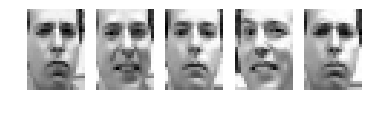

In [3]:
print(images.shape)
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(images[i])
  plt.axis('off')
plt.show()

We split the data into training and testing splits (the data was shuffled above) and then convert to floating point on [-1 1] range.

In [4]:
x_train = images[0:1800]
x_test = images[1800:]
x_train = (x_train.astype('float32')/255.)*2-1
x_test = (x_test.astype('float32')/255.)*2-1

## Model implementation and training

The code to build a linear autoencoder is given here.  Modify it to have multiple hidden layers with ReLU activation in the encoder and decoder.

### Encoder:
* Dense with 512 hidden units, ReLU activation
* Dense with 512 hidden units, ReLU activation
* Dense with 2 hidden units, tanh activation

### Decoder:
* Dense with 512 hidden units, ReLU activation
* Dense with 512 hidden units, ReLU activation
* Dense with 28*20 hidden units, linear activation


In [90]:
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

class Autoencoder:
  def __init__(self):
    # Encoder Layers
    self.e_d1 = Dense(512, activation='relu', name='encoder_dense_1')
    self.e_d2 = Dense(512, activation='relu', name='encoder_dense_2')
    self.encoder_layer = Dense(2,activation='tanh',name='encoder')
    # Decoder Layers
    self.d_d1 = Dense(512, activation='relu', name='decoder_dense_1')
    self.d_d2 = Dense(512, activation='relu', name='decoder_dense_2')
    self.decoder_layer = Dense(28*20,activation='linear',name='decoder')
    
  def get_autoencoder(self):
    """ Builds the full autoencoder model with encoder and decoder. """
    inputs = Input((28,20),name='autoencoder_input')
    x = Flatten()(inputs)
    x = self.e_d1(x)
    x = self.e_d2(x)
    x = self.encoder_layer(x)
    x = self.d_d1(x)
    x = self.d_d2(x)
    x = self.decoder_layer(x)
    outputs = Reshape((28,20))(x)
    return Model(inputs=inputs,outputs=outputs)
  
  def get_encoder(self):
    """ Builds just the encoder model. """
    inputs = Input((28,20),name='encoder_input')
    x = Flatten()(inputs)
    x = self.e_d1(x)
    x = self.e_d2(x)
    x = self.encoder_layer(x)
    return Model(inputs=inputs,outputs=x)
  
  def get_decoder(self):
    """ Builds just the decoder model. """
    embedding = Input((2,),name='decoder_input')
    x = embedding
    x = self.d_d1(x)
    x = self.d_d2(x)
    x = self.decoder_layer(x)
    outputs = Reshape((28,20))(x)
    return Model(inputs=embedding,outputs=outputs)

autoencoder = Autoencoder()

ae_model = autoencoder.get_autoencoder()
encoder_model = autoencoder.get_encoder()
decoder_model = autoencoder.get_decoder()

ae_model.compile(SGD(0.01,momentum=0.9),loss='mean_absolute_error')
print(ae_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 28, 20)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 560)               0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 512)               287232    
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 512)               262656    
_________________________________________________________________
encoder (Dense)              (None, 2)                 1026      
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 512)               1536      
_________________________________________________________________
decoder_dense_2 (Dense)      (None, 512)               262656    
__________

In [91]:
history = ae_model.fit(x_train,x_train,batch_size=32,epochs=1000,verbose=True,validation_split=0.1)

Train on 1620 samples, validate on 180 samples
Epoch 1/1000
1620/1620 [==============================] - 1s 340us/step - loss: 0.3334 - val_loss: 0.3302
Epoch 2/1000
1620/1620 [==============================] - 0s 81us/step - loss: 0.3256 - val_loss: 0.3215
Epoch 3/1000
1620/1620 [==============================] - 0s 78us/step - loss: 0.3155 - val_loss: 0.3098
Epoch 4/1000
1620/1620 [==============================] - 0s 84us/step - loss: 0.3015 - val_loss: 0.2936
Epoch 5/1000
1620/1620 [==============================] - 0s 82us/step - loss: 0.2820 - val_loss: 0.2701
Epoch 6/1000
1620/1620 [==============================] - 0s 82us/step - loss: 0.2530 - val_loss: 0.2366
Epoch 7/1000
1620/1620 [==============================] - 0s 82us/step - loss: 0.2164 - val_loss: 0.1998
Epoch 8/1000
1620/1620 [==============================] - 0s 82us/step - loss: 0.1814 - val_loss: 0.1705
Epoch 9/1000
1620/1620 [==============================] - 0s 84us/step - loss: 0.1599 - val_loss: 0.1580
Epoch 1

Epoch 78/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1382 - val_loss: 0.1407
Epoch 79/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1377 - val_loss: 0.1401
Epoch 80/1000
1620/1620 [==============================] - 0s 71us/step - loss: 0.1373 - val_loss: 0.1396
Epoch 81/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1368 - val_loss: 0.1391
Epoch 82/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1364 - val_loss: 0.1386
Epoch 83/1000
1620/1620 [==============================] - 0s 71us/step - loss: 0.1359 - val_loss: 0.1381
Epoch 84/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1355 - val_loss: 0.1376
Epoch 85/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1350 - val_loss: 0.1371
Epoch 86/1000
1620/1620 [==============================] - 0s 71us/step - loss: 0.1346 - val_loss: 0.1366
Epoch 87/1000
1620/1620 [=====================

Epoch 155/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1236 - val_loss: 0.1255
Epoch 156/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1235 - val_loss: 0.1254
Epoch 157/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1235 - val_loss: 0.1253
Epoch 158/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1234 - val_loss: 0.1253
Epoch 159/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1233 - val_loss: 0.1252
Epoch 160/1000
1620/1620 [==============================] - 0s 72us/step - loss: 0.1232 - val_loss: 0.1251
Epoch 161/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1231 - val_loss: 0.1251
Epoch 162/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1230 - val_loss: 0.1250
Epoch 163/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1229 - val_loss: 0.1249
Epoch 164/1000
1620/1620 [===========

1620/1620 [==============================] - 0s 68us/step - loss: 0.1192 - val_loss: 0.1216
Epoch 232/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1191 - val_loss: 0.1215
Epoch 233/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1191 - val_loss: 0.1215
Epoch 234/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1190 - val_loss: 0.1214
Epoch 235/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1190 - val_loss: 0.1214
Epoch 236/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1189 - val_loss: 0.1213
Epoch 237/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1189 - val_loss: 0.1213
Epoch 238/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1188 - val_loss: 0.1212
Epoch 239/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1188 - val_loss: 0.1212
Epoch 240/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 71us/step - loss: 0.1149 - val_loss: 0.1176
Epoch 308/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1148 - val_loss: 0.1175
Epoch 309/1000
1620/1620 [==============================] - 0s 71us/step - loss: 0.1148 - val_loss: 0.1174
Epoch 310/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1147 - val_loss: 0.1174
Epoch 311/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1146 - val_loss: 0.1173
Epoch 312/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1146 - val_loss: 0.1173
Epoch 313/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1145 - val_loss: 0.1172
Epoch 314/1000
1620/1620 [==============================] - 0s 71us/step - loss: 0.1145 - val_loss: 0.1172
Epoch 315/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1144 - val_loss: 0.1171
Epoch 316/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 69us/step - loss: 0.1109 - val_loss: 0.1140
Epoch 384/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1109 - val_loss: 0.1140
Epoch 385/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1109 - val_loss: 0.1139
Epoch 386/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1108 - val_loss: 0.1139
Epoch 387/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1108 - val_loss: 0.1139
Epoch 388/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1107 - val_loss: 0.1138
Epoch 389/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1107 - val_loss: 0.1138
Epoch 390/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1107 - val_loss: 0.1138
Epoch 391/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1106 - val_loss: 0.1137
Epoch 392/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 68us/step - loss: 0.1087 - val_loss: 0.1118
Epoch 460/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1087 - val_loss: 0.1119
Epoch 461/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1087 - val_loss: 0.1118
Epoch 462/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1086 - val_loss: 0.1118
Epoch 463/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1086 - val_loss: 0.1117
Epoch 464/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1086 - val_loss: 0.1117
Epoch 465/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1086 - val_loss: 0.1117
Epoch 466/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1086 - val_loss: 0.1117
Epoch 467/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1085 - val_loss: 0.1117
Epoch 468/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 71us/step - loss: 0.1072 - val_loss: 0.1102
Epoch 536/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1072 - val_loss: 0.1102
Epoch 537/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1071 - val_loss: 0.1102
Epoch 538/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1071 - val_loss: 0.1101
Epoch 539/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1071 - val_loss: 0.1101
Epoch 540/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1071 - val_loss: 0.1101
Epoch 541/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1071 - val_loss: 0.1101
Epoch 542/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1071 - val_loss: 0.1101
Epoch 543/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1070 - val_loss: 0.1100
Epoch 544/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 68us/step - loss: 0.1059 - val_loss: 0.1088
Epoch 612/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1059 - val_loss: 0.1087
Epoch 613/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1059 - val_loss: 0.1087
Epoch 614/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1059 - val_loss: 0.1087
Epoch 615/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1058 - val_loss: 0.1087
Epoch 616/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1058 - val_loss: 0.1087
Epoch 617/1000
1620/1620 [==============================] - 0s 67us/step - loss: 0.1058 - val_loss: 0.1087
Epoch 618/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1058 - val_loss: 0.1086
Epoch 619/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1058 - val_loss: 0.1086
Epoch 620/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 69us/step - loss: 0.1047 - val_loss: 0.1076
Epoch 688/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1047 - val_loss: 0.1076
Epoch 689/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1047 - val_loss: 0.1076
Epoch 690/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1047 - val_loss: 0.1076
Epoch 691/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1047 - val_loss: 0.1075
Epoch 692/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1047 - val_loss: 0.1075
Epoch 693/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1047 - val_loss: 0.1075
Epoch 694/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1047 - val_loss: 0.1075
Epoch 695/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1046 - val_loss: 0.1075
Epoch 696/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 68us/step - loss: 0.1037 - val_loss: 0.1067
Epoch 764/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1037 - val_loss: 0.1067
Epoch 765/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1037 - val_loss: 0.1067
Epoch 766/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1037 - val_loss: 0.1067
Epoch 767/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1037 - val_loss: 0.1067
Epoch 768/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1036 - val_loss: 0.1067
Epoch 769/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1036 - val_loss: 0.1066
Epoch 770/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1036 - val_loss: 0.1066
Epoch 771/1000
1620/1620 [==============================] - 0s 69us/step - loss: 0.1036 - val_loss: 0.1067
Epoch 772/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 68us/step - loss: 0.1027 - val_loss: 0.1061
Epoch 840/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1028 - val_loss: 0.1061
Epoch 841/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1027 - val_loss: 0.1061
Epoch 842/1000
1620/1620 [==============================] - 0s 77us/step - loss: 0.1027 - val_loss: 0.1061
Epoch 843/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1027 - val_loss: 0.1061
Epoch 844/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1027 - val_loss: 0.1061
Epoch 845/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1027 - val_loss: 0.1061
Epoch 846/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1027 - val_loss: 0.1060
Epoch 847/1000
1620/1620 [==============================] - 0s 78us/step - loss: 0.1026 - val_loss: 0.1060
Epoch 848/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 81us/step - loss: 0.1019 - val_loss: 0.1057
Epoch 916/1000
1620/1620 [==============================] - 0s 89us/step - loss: 0.1019 - val_loss: 0.1057
Epoch 917/1000
1620/1620 [==============================] - 0s 73us/step - loss: 0.1018 - val_loss: 0.1056
Epoch 918/1000
1620/1620 [==============================] - 0s 73us/step - loss: 0.1018 - val_loss: 0.1057
Epoch 919/1000
1620/1620 [==============================] - 0s 75us/step - loss: 0.1018 - val_loss: 0.1056
Epoch 920/1000
1620/1620 [==============================] - 0s 73us/step - loss: 0.1018 - val_loss: 0.1056
Epoch 921/1000
1620/1620 [==============================] - 0s 82us/step - loss: 0.1018 - val_loss: 0.1056
Epoch 922/1000
1620/1620 [==============================] - 0s 79us/step - loss: 0.1018 - val_loss: 0.1056
Epoch 923/1000
1620/1620 [==============================] - 0s 71us/step - loss: 0.1018 - val_loss: 0.1056
Epoch 924/1000
1620/1620 [==========================

1620/1620 [==============================] - 0s 68us/step - loss: 0.1010 - val_loss: 0.1053
Epoch 992/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1010 - val_loss: 0.1053
Epoch 993/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1010 - val_loss: 0.1053
Epoch 994/1000
1620/1620 [==============================] - 0s 76us/step - loss: 0.1010 - val_loss: 0.1053
Epoch 995/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1010 - val_loss: 0.1053
Epoch 996/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1010 - val_loss: 0.1053
Epoch 997/1000
1620/1620 [==============================] - 0s 70us/step - loss: 0.1010 - val_loss: 0.1052
Epoch 998/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1010 - val_loss: 0.1053
Epoch 999/1000
1620/1620 [==============================] - 0s 68us/step - loss: 0.1010 - val_loss: 0.1053
Epoch 1000/1000
1620/1620 [=========================

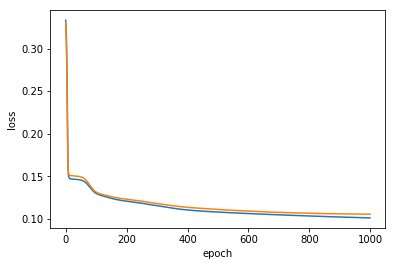

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Exercises

*Before doing any of these exercises, make sure to modify the model as described above.*

* Test the ability of the autoencoder to compress and decompress the images.  Compare some input images to their reconstructions after running the autoencoder.  What effect does the autoencoder have on the images?
* VIsualize the output of the encoder (run on the training data) as a scatter plot.  Give some observations about the output.  Does it seem to be using all of the possible output space?
* Generate new faces by making a grid of embedding points on $[-1~1]\times[-1~1]$ (see code below).  Give some observations about the resulting images.
* Test interpolation between two images (see the example from the autoencoder notebook).  Give some observations about the output.
* Set up another autoencoder and train it on the spiral data from HW1.1. Visualize the embedding that it produces.  Does it produce an embedding where the separate spirals are linearly separable?  Does the autoencoder learn to map the spirals to tight, separated clusters?  (You might want to use linear activation rather than tanh for the encoder output in this part.)

This code makes a 10x10 grid of points from -1 to 1 in each dimension.

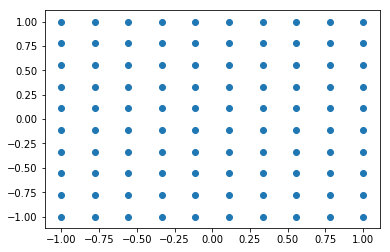

In [93]:
coords = np.linspace(-1,1,num=10)
x,y = np.meshgrid(coords,coords,indexing='xy')
embeddings = np.stack([x.flatten(),y.flatten()],axis=1)
plt.scatter(embeddings[:,0],embeddings[:,1])
plt.show()

##### 1. Test the ability of the autoencoder to compress and decompress the images. Compare some input images to their reconstructions after running the autoencoder. What effect does the autoencoder have on the images?

From the examples below, the autoencoder with multiple hidden layers is able to closely replicate the original images. One noticable difference is that the reconstructred images look slightly darker than the original images in areas that used to be white (check out the man's forehead) and the opposite affect is also true as darker spots in the original image appear slightly lighter than the original representation. It appears that the largest differences between the original and the reconstructed images appear at the man's mouth. In the first and second reconstructed images, the tongue is no longer in the image. Overall, I was surprised that the autoencoder only obtained a loss of ~10% during validation since the encoder compresses the image into just two nodes!

Row 1 = Input Images
Row 2 = Reconstructed Images


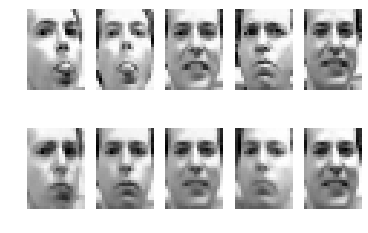

In [94]:
# Example input images and their reconstructions:
length = 5
images_in = x_test[:length]
# Run the autoencoder on each image
images_out = ae_model.predict(images_in)
print("Row 1 = Input Images\nRow 2 = Reconstructed Images")
# Display results
for i in range(length):
  plt.subplot(2,length,i+1)
  plt.imshow(images_in[i])
  plt.axis('off')
for i in range(length):
  plt.subplot(2,length,i+length+1)
  plt.imshow(images_out[i])
  plt.axis('off')
plt.show()

##### 2. Visualize the output of the encoder (run on the training data) as a scatter plot. Give some observations about the output. Does it seem to be using all of the possible output space?

When the latent values are plotted in two dimensions, the training data appears to be clustered in areas were X is between -0.75 and -0.50 and where Y is less than 0.75. There does not seem to be an even distribution of points throughout the scatterplot. This leaves much of the output space, which ranges $[-1~1]\times[-1~1]$ empty. Specifically, there are very few points where X is between 0 and 1 and Y is between -1 and 0. We can experiment with a greater range of images by sampling points from the entire breadth and depth of the output space.

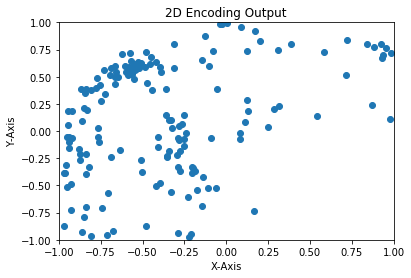

In [95]:
images_out = encoder_model.predict(x_test)
x = [x[0] for x in images_out]
y = [x[1] for x in images_out]
plt.scatter(x, y)
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.title("2D Encoding Output")
plt.ylim(-1,1)
plt.xlim(-1,1)
plt.show()

##### 3. Generate new faces by making a grid of embedding points on  [−1 1]×[−1 1]  (see code below). Give some observations about the resulting images.

Sampling images across the entire output space gives us an idea of how the decoder is working. The following patterns can be observed:
    1. The man's face changes directions from right to left across the main diagonal.
    2. The man's mouth changes from a blurry tongue-like figure to a smile across the off diagonal (the bottom left images to the top right image).
    3. The man's tongue is not completely visible in any of the images.

PS: Sorry for the small images. I could not figure out how to make them bigger :(

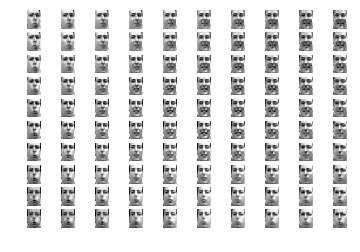

In [109]:
# Generate an image from each area in the output space
embeddings.shape
images = decoder_model.predict(embeddings)

width = height = 10
totalPoints = width * height
for i in range(totalPoints):
  plt.subplot(width,height,i+1)
  plt.imshow(np.squeeze(images[i]))
  plt.axis('off')

##### 4. Test interpolation between two images (see the example from the autoencoder notebook). Give some observations about the output.

The output of the interpolate_between function is as follows: The first row of images represent the output images for the autoencoder and the bottom two images in the second row are the original images from imgA and imgB from the interpolate_between function. 

I have chosen to interpolate between two different pairs of images. 
In the first pair, the man is sticking his tongue out and facing to the right and in the second image, the man is sticking his tongue out and is facing toward the camera. In the interpolation, none of the images show the tongue. However, the man slowly turns his head to face the camera. 
In the second pair, the man is frowning and in the second image, the man is smiling. As you can see, the output images of the autoencoder slowly transforms the frown into a smile by slowly opening and reshaping his lips.

The output of both interpolations is very interesting because the autoencoder creates smooth transitions between the two images!

In [146]:
def interpolate_between(imgA_index,imgB_index):
  imgA = x_test[imgA_index]
  imgB = x_test[imgB_index]
  
  imgA_encoded = encoder_model.predict(x_test[imgA_index:(imgA_index+1)])
  imgB_encoded = encoder_model.predict(x_test[imgB_index:(imgB_index+1)])
  
  numAlphas = 10
  alphas = np.linspace(0,1,num=numAlphas)
  for n in range(10):
    alpha = alphas[n]
    img_encoded = (1-alpha)*imgA_encoded+alpha*imgB_encoded
    img = decoder_model.predict(img_encoded)
    plt.subplot(2,10,n+1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
  plt.subplot(2,10,numAlphas+1)
  plt.imshow(np.squeeze(imgA))
  plt.axis('off')
  plt.subplot(2,10,numAlphas+2)
  plt.imshow(np.squeeze(imgB))
  plt.axis('off')
  plt.subplots_adjust(top = 0.5, bottom=0, hspace=0, wspace=0.4)
  plt.show()

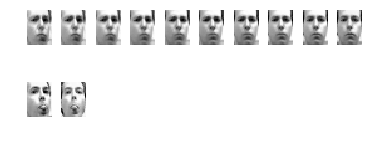

In [147]:
interpolate_between(0,1)

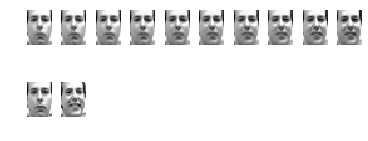

In [165]:
interpolate_between(5,14)

##### 5. Set up another autoencoder and train it on the spiral data from HW1.1. Visualize the embedding that it produces. Does it produce an embedding where the separate spirals are linearly separable? Does the autoencoder learn to map the spirals to tight, separated clusters? (You might want to use linear activation rather than tanh for the encoder output in this part.)

